In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp 
import os, sys
import matplotlib as mpl
from matplotlib import pylab as plt
#import seaborn as sb
#import holoviews
#from holoviews import *
#%load_ext holoviews.ipython

In [2]:
from datetime import timedelta, datetime
def timecodematch(x, base_date):
    delta = []
    b_d = datetime.strptime(base_date, "%H:%M:%S:%f")
    for y in range(len(x)):
        d = datetime.strptime(x[y], "%H:%M:%S:%f")
        delta.append(abs(d - b_d))
    return delta

# Reading Accel data

In [ ]:
# Read in data for each subject between start and end times
sub = ['7','8','17','30','37','50','66','78','82','84','88','90','96','97']
#
# Not running: '6', '10','26','27','36', '43','71', '72','80','85','91','92',

sampling_freq = 1000 # in milliseconds
beginTS = '20:33:00:001'
endTS   = '21:03:00:002'
da = datetime.strptime(endTS, "%H:%M:%S:%f") - datetime.strptime(beginTS, "%H:%M:%S:%f")
totMS = ((da.seconds * 1000000) + da.microseconds) / 1000

gforce_all = []
for s in sub:
    print s
    df = pd.read_csv('/Users/dmargulies/Dropbox/01_code/ravestudy/data/%s.csv' % str(s), delimiter=';')
    #print df['time'].get_values()[0]
    #print df['time'].get_values()[-1]
    startTime = np.argmin(timecodematch(df['time'].get_values(), beginTS))
    endTime = np.argmin(timecodematch(df['time'].get_values(), endTS))

    # instead, try interpolating to specific time intervals:
    time_s = df['time'].get_values()[startTime:endTime]
    gforce_s = df['gforce'].get_values()[startTime:endTime]

    ts = timecodematch(time_s, beginTS)
    for t in range(len(time_s)):
        time_s[t] = ((ts[t].seconds * 1000000) + ts[t].microseconds) / 1000

    # !!! check abs and -1 here !!!
    gforce_all.append(abs(np.interp(range(0,totMS,sampling_freq), 
                                np.array(time_s, dtype=np.float64), 
                                np.array(gforce_s, dtype=np.float64)))-1)
    
gforce_mean = np.mean(gforce_all, axis=0)

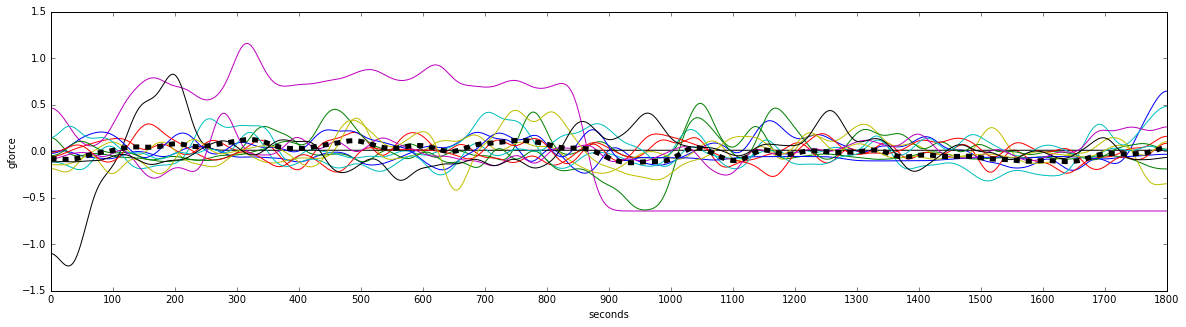

In [86]:
# Smoothing:

from scipy.ndimage.filters import gaussian_filter


gforce_all_normed = []
for i in range(len(gforce_all)):
    gforce_all_normed.append((gforce_all[i] - np.mean(gforce_all[i])) / np.std(gforce_all[i]))

gforce_all_smoothed = []
for i in range(len(gforce_all)):
    gforce_all_smoothed.append(gaussian_filter(gforce_all_normed[i], sigma=20))

gforce_mean = np.mean(gforce_all_smoothed, axis=0)

# Plotting:

fig, ax1 = plt.subplots(1,figsize=(20,5))
for i in range(len(gforce_all_smoothed)):
    ax1.plot(gforce_all_smoothed[i])

ax1.plot(gforce_mean, 'k',linewidth=5,  linestyle='--')
plt.xticks(range(0,len(gforce_mean), 100), np.array(range(0,totMS,sampling_freq*100))/1000, rotation='0')
ax1.set_xlabel('seconds')
ax1.set_ylabel('gforce')
plt.show()

In [85]:
1500/60


25

In [404]:
# For clustering, try: https://github.com/alexminnaar/time-series-classification-and-clustering


In [ ]:
import pyaudio  
import wave  

In [ ]:
#define stream chunk   
chunk = 1024  

#open a wav format music  
f = wave.open(r"/usr/share/sounds/alsa/Rear_Center.wav","rb")  
#instantiate PyAudio  
p = pyaudio.PyAudio()  
#open stream  
stream = p.open(format = p.get_format_from_width(f.getsampwidth()),  
                channels = f.getnchannels(),  
                rate = f.getframerate(),  
                output = True)  
#read data  
data = f.readframes(chunk)  

#paly stream  
while data != '':  
    stream.write(data)  
    data = f.readframes(chunk)  

#stop stream  
stream.stop_stream()  
stream.close()  

#close PyAudio  
p.terminate()  

In [28]:
gforce_stack = holoviews.HoloMap(kdims=['Observation error','Random error'])
gforce_stack = TimeSeries(np.array(gforce_all), label='gforce', group='Activity', kdims=['Time', 'Observation'])

:TimeSeries   [Time,Observation]   (z)
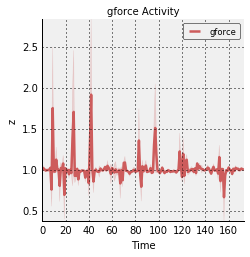

:TimeSeries   [Time,Observation]   (z)
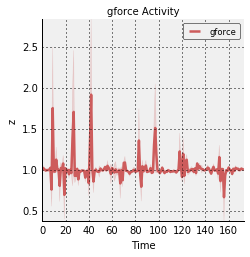

In [29]:
%%opts TimeSeries [apply_databounds=True] (ci=95 color='indianred')
gforce_stack

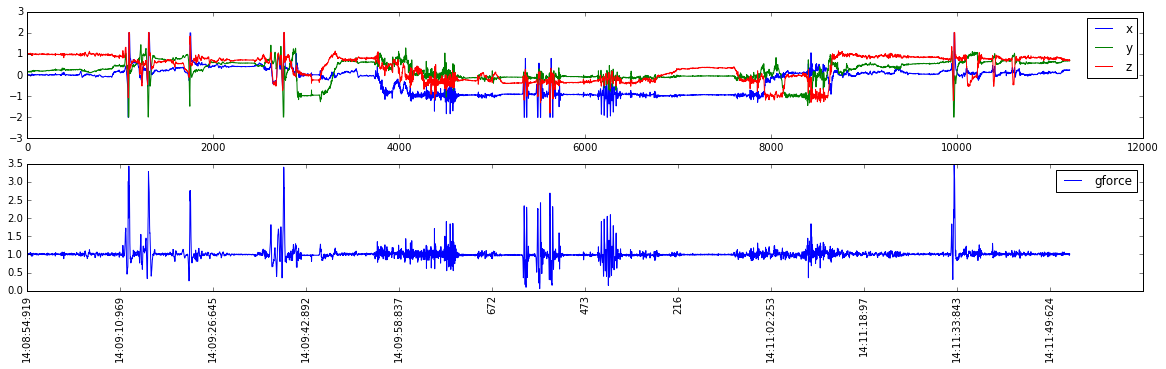

In [334]:
fig, (ax1,ax2) = plt.subplots(2,figsize=(20,5))
ax1.plot(df['x'])
ax1.plot(df['y'])
ax1.plot(df['z'])
ax1.legend()

ax2.plot(df['gforce'])
ax2.legend()

tp_interval=1000
plt.xticks(range(0,len(df['time']),tp_interval), df['time'][range(0,len(df['time']),tp_interval)], rotation='90')

plt.show()

# Reading sound .amr file

In [113]:
# Convert between network and filesystem views of AMR files
# E. Woudenberg, Lobby7 Feb 2003
# Tested under WinXP/Cygwin

import os, sys, struct, array

class nibble_reader:
    def __init__(self, data):
        self.data = array.array('B', data)
        self.i = 0
    def read(self):
        if self.i/2 >= len(self.data):
            return None
        c = self.data[self.i/2]
        if self.i % 2:
            c >>= 4
        c &= 0xF
        self.i += 1
        return c

class nibble_writer:
    def __init__(self):
        self.out = array.array('B')
        self.i = 0
    def write(self, n):
        if self.i % 2:
            self.out[self.i/2] |= n<<4;
        else:
            self.out.append(n)
        self.i += 1
    def tostring(self):
        return self.out.tostring()

def makefliptab():
    global fliptab
    fliptab = []
    for i in range(256):
        fliptab.append(bytflip(i))

def bytflip(n):
    return nybflip(n>>4) + (nybflip(n&0xf)<<4)

def nybflip(n):
    f = ((n&1)<<3) + ((n&2)<<1) + ((n&4)>>1) + ((n&8)>>3)
# print '%d%d%d%d' % ((f&8!=0),(f&4!=0),(f&2!=0),(f&1!=0))
    return f

# AMR file has bits in Network Bit Order, which is most significant bit
# first. Here we mirror them to restore their order.

def flip_bitorder(b):
    a = array.array('B',b)
    for i in range(len(a)):
        a[i] = fliptab[a[i]]
    return a.tostring()

Framebits = [95,103,118,134,148,159,204,244]

def amr2if2(inf, outf):
    
    outD = []
    
    f = open(inf,'rb')
    fw = open(outf, 'wb')

    head = f.read(6)
    if head != '#!AMR\n':
        print 'not an #!AMR file'
        sys.exit(1)

    frameno = 0
    while 1:
        ft = f.read(1)
        if len(ft) == 0: break
        fb = struct.unpack('B', ft)[0]
        if not (fb & 4):
            print 'invalid frame at frameno %d, exiting' % frameno
            sys.exit(1)
        ftype = (fb >> 3) & 0xF
        fsize = (Framebits[ftype]+7)/8
        # print 'frametype', ftype, 'framesize', fsize
        frame = f.read(fsize)
        nr = nibble_reader(flip_bitorder(frame))
        nw = nibble_writer()
        nw.write(ftype)
        while 1:
            n = nr.read()
            if n == None: break
            nw.write(n)
        outfsize = (Framebits[ftype]+4+7)/8 # round to byte count, include ftype nibble        
        fw.write(nw.tostring()[:outfsize])

        outD.append(nw.out)
        
        frameno += 1
    print 'Processed %d frames, created %s' % (frameno, outf)
    return outD


In [114]:
makefliptab()
nr = amr2if2('data/%s.amr' % str(sub), 'data/%s.cod' % str(sub))

Processed 5683 frames, created data/92.cod


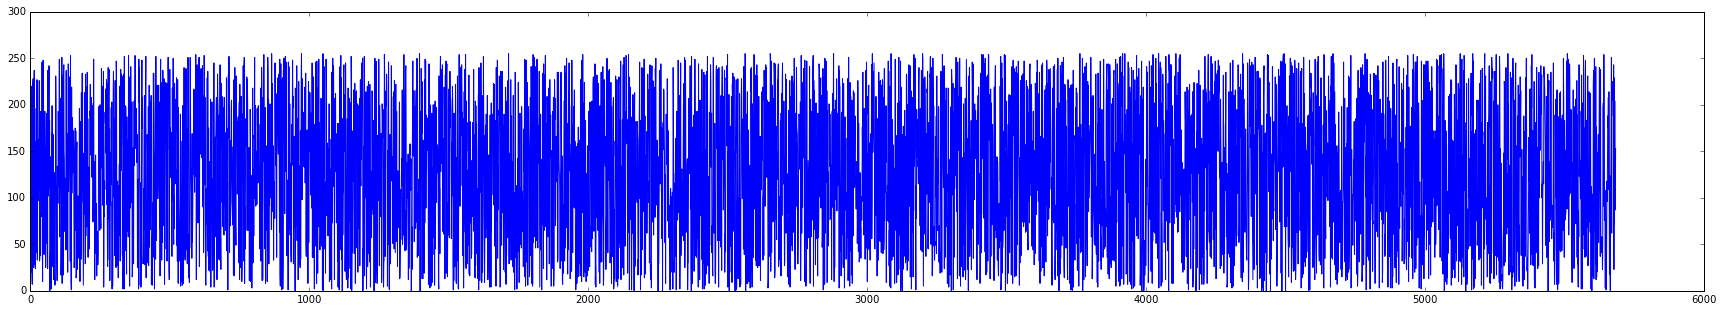

In [154]:
plt.subplots(figsize=(30,5))
plt.plot(np.array(nr).T[29])